In [4]:
import cvxopt
import numpy as np
import os
from PIL import Image
from sklearn.svm import SVC as svm
import pickle
import time
import shutil
C = 1 ; gamma = 0.001

In [5]:
def resize(img) :
    img = np.array(img.resize((16,16)))
    return img.reshape(img.shape[0]*img.shape[1]*img.shape[2])/255

def loadClass(path):
    images = []
    for i in os.listdir(path):
        images.append(resize(Image.open(os.path.join(path,i))))
    return np.array(images)

def loadSVMData(c1,c2):
    class0 = loadClass(c1)
    label0 = (-1)*np.ones((class0.shape[0],1))
    class1 = loadClass(c2)
    label1 = np.ones((class1.shape[0],1))
    return np.concatenate([class0,class1]) ,np.concatenate([label0,label1])

In [6]:
def getSupport(arr,tol = 1e-3, C = 1):
    supportAlpha = []; indices = []
    for i in range(len(arr)):
        if arr[i] > tol :
            supportAlpha.append(arr[i])
            indices.append(i)
    return supportAlpha,indices

def linearKernel(X1,X2):
    return np.matmul(X1,X2.T)

def gaussKernel(X1: np.ndarray, X2: np.ndarray, gamma: float = 0.001):
    prod = np.reshape(np.einsum('ij,ij->i', X1, X1), (X1.shape[0], 1)) + \
           np.reshape(np.einsum('ij,ij->i', X2, X2), (X2.shape[0], 1)).T \
             - 2 * np.matmul(X1, X2.T)
    return np.exp(-gamma * prod)

def SVM(X, Y, kernel = 'gaussian' , gamma = 0.1, C = 1, tol = 1e-4,showProg = False):
    if kernel == 'linear':
        kernelMatrix = linearKernel(X,X)
    elif kernel == 'gaussian': 
        kernelMatrix = gaussKernel(X,X,gamma = gamma)
    print("kernel computed")

    P = cvxopt.matrix((kernelMatrix * np.matmul(Y,Y.T)))
    q = cvxopt.matrix(-np.ones(X.shape[0]))
    c = 0
    G = cvxopt.matrix(np.concatenate([np.eye(X.shape[0]),(-1)*np.eye(X.shape[0])]))
    h = cvxopt.matrix(np.concatenate([C*np.ones((X.shape[0],1)),np.zeros((X.shape[0],1))]))
    A = cvxopt.matrix(Y.T ,tc = 'd')
    b = cvxopt.matrix(0.0)

    sol = cvxopt.solvers.qp(P, q, G, h, A, b, options={'show_progress': showProg})
    alphaRaw = np.array(sol['x'])
    supportAlpha, supportIndices = getSupport(alphaRaw,tol, C)
    supportAlpha = np.array(supportAlpha)
    ySupport = Y[supportIndices]; xSupport = X[supportIndices]

    w = np.sum(supportAlpha * ySupport * xSupport , axis = 0)

    wXt = np.sum(alphaRaw * Y * kernelMatrix,axis = 0)

    M = max(supportIndices, key=lambda i: -float("inf") if Y[i] == 1  or C - alphaRaw[i] <= tol else wXt[i])
    m = min(supportIndices, key=lambda i: float("inf") if Y[i] == -1  or C - alphaRaw[i] <= tol else wXt[i])
    intercept = -(wXt[M] + wXt[m]) / 2
    return w,intercept,alphaRaw, supportIndices



In [3]:
savePath = 'SVM_modelsQ2'
if not os.path.exists(savePath):
        os.mkdir(savePath)

In [13]:
# TRAINING ALL SVM MODELS
# to store : alphaRawGaussian, bGaussian and supportGaussian. Load trainX and trainY at time of prediction
CLASSES = 6
savePath = 'SVM_modelsQ2'
modelsDict = {}
netTime = 0
for i in range(CLASSES):
    for j in range(i+1,CLASSES):
        print(f'Training for class-{i} and class-{j}')
        trainX, trainY = loadSVMData('data/svm/train/'+str(i),'data/svm/train/'+str(j)) 
        tLocal = time.time()
        _ , bGaussian ,alphaRawGaussian ,supportGaussian = SVM(trainX,trainY, kernel = 'gaussian',gamma = 0.001,showProg = False, tol=1e-3, C = 1.0)
        netTime += time.time() - tLocal
        print(f'Time taken for {i} and {j} = {time.time() - tLocal : .3f}')

        #CHECKPOINTS
        with open(os.path.join(savePath,f'model{i}{j}.pickle'),'wb') as f:
            pickle.dump({'intercept' : bGaussian, 'alphaRaw' : alphaRawGaussian, 'supportIndices' : supportGaussian}, f)

        modelsDict[(i,j)] = {'intercept' : bGaussian, 'alphaRaw' : alphaRawGaussian, 'supportIndices' : supportGaussian}

Training for class-0 and class-1
kernel computed
Time taken for 0 and 1 =  60.494
Training for class-0 and class-2
kernel computed
Time taken for 0 and 2 =  44.819
Training for class-0 and class-3
kernel computed
Time taken for 0 and 3 =  47.495
Training for class-0 and class-4
kernel computed
Time taken for 0 and 4 =  39.933
Training for class-0 and class-5
kernel computed
Time taken for 0 and 5 =  46.462
Training for class-1 and class-2
kernel computed
Time taken for 1 and 2 =  63.255
Training for class-1 and class-3
kernel computed
Time taken for 1 and 3 =  71.445
Training for class-1 and class-4
kernel computed
Time taken for 1 and 4 =  60.602
Training for class-1 and class-5
kernel computed
Time taken for 1 and 5 =  46.700
Training for class-2 and class-3
kernel computed
Time taken for 2 and 3 =  50.349
Training for class-2 and class-4
kernel computed
Time taken for 2 and 4 =  42.861
Training for class-2 and class-5
kernel computed
Time taken for 2 and 5 =  58.163
Training for cla

In [15]:
with open(os.path.join(savePath,'allaCombined.pickle'),'wb') as f:
    pickle.dump(modelsDict,f)

In [8]:
with open('SVM_modelsQ2/allaCombined.pickle','rb') as f:
    modelsDict = pickle.load(f)

In [10]:
CLASSES = 6
for i in range(CLASSES):
    for j in range(i+1,CLASSES):
        trainX, trainY = loadSVMData('../../data/svm/train/'+str(i),'../../data/svm/train/'+str(j))
        modelsDict[(i,j)]['trainX'] = trainX
        modelsDict[(i,j)]['trainY'] = trainY

In [50]:
def testAccij(modelsDict, i,j) :
    testX, testY = loadSVMData('data/svm/val/'+str(i),'data/svm/val/'+str(j))
    pred = np.sum(modelsDict[(i,j)]['alphaRaw'][modelsDict[(i,j)]['supportIndices']] * modelsDict[(i,j)]['trainY'][modelsDict[(i,j)]['supportIndices']] * gaussKernel(modelsDict[(i,j)]['trainX'][modelsDict[(i,j)]['supportIndices']], testX, 0.001), 0) + modelsDict[(i,j)]['intercept']
    pred = np.where(pred>=0, 1, -1)
    accGauss = np.where((testY.flatten() == pred) == True)[0].shape[0]/testY.shape[0]
    print(f'Validation set accuracy = {accGauss*100 : .3f}%')

In [39]:
def getVotes(X,modelsDict):
    votes = {i:0 for i in range(CLASSES)}
    max_score = {i:0 for i in range(CLASSES)}
    X = X.reshape((1,X.shape[0]))
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            pred = np.sum(modelsDict[(i,j)]['alphaRaw'][modelsDict[(i,j)]['supportIndices']] * modelsDict[(i,j)]['trainY'][modelsDict[(i,j)]['supportIndices']] \
                       * gaussKernel(modelsDict[(i,j)]['trainX'][modelsDict[(i,j)]['supportIndices']], X, 0.001), 0) + modelsDict[(i,j)]['intercept']
            predNum = np.where(pred <= 0 , i, j)[0]
            max_score[predNum] = max(max_score[predNum],pred[0])
            votes[predNum]+=1
    votes = {j:i for i,j in votes.items()}
    votes =  sorted(list(votes.items()))
    result = -1
    if votes[-1][0] == votes[-2][0]:
        if max_score[votes[-1][-1]] > max_score[votes[-2][-1]]:
            result = votes[-1][-1]
        else:
            result = votes[-2][1]
    else:
        result = votes[-1][1]
    return result

In [40]:
getVotes(testX[2],modelsDict)

0

In [15]:
def loadAllClasses(tv = 'val'):

    class0 = loadClass('../../data/svm/'+tv+'/0')
    label0 = 0*np.ones((class0.shape[0],1))
    for i in range(1,6):
        class1 = loadClass('../../data/svm/'+ tv+ '/' + str(i))
        label1 = i*np.ones((class1.shape[0],1))
        class0, label0 = np.concatenate([class0,class1]) ,np.concatenate([label0,label1])
    return class0, label0

In [16]:
testX, testY = loadAllClasses()

In [54]:

trainX, trainY = loadAllClasses('train')

In [41]:
matches = 0
predsCustomSVM = []
for i in range(testX.shape[0]):
    predsCustomSVM.append(getVotes(testX[i],modelsDict))
    if predsCustomSVM[-1] == testY[i][-1] : matches += 1

In [42]:
matches/testX.shape[0]

0.5591666666666667

In [56]:
from sklearn.svm import SVC
gaussSVM = SVC( kernel='rbf', gamma = 0.001, C = 1)
t = time.time()
gaussSVM.fit(trainX, trainY.flatten())
time.time() - t

86.37898397445679

In [58]:
np.where(gaussSVM.predict(testX) == testY.flatten())[0].shape[0]/testY.shape[0]

0.5608333333333333

In [61]:
testY.shape

(1200, 1)

In [65]:
from sklearn.metrics import confusion_matrix as cm
import pandas as pd
matrix = cm(testY.flatten(),predsCustomSVM)
cm_df = pd.DataFrame(matrix,dtype=np.int32)
print("The confusion matrix for the given task using custom SVM : ")
cm_df

The confusion matrix for the given task using custom SVM : 


,0,1,2,3,4,5
0,76,21,22,24,26,31
1,5,154,1,5,11,24
2,7,4,127,24,25,13
3,26,6,24,128,12,4
4,25,16,56,36,59,8
5,21,23,9,7,13,127


In [87]:
vecs

[array([ 544,  906,  942,  746,  514,   99, 1090,  111, 1130,   87,  126,
         124])]

In [94]:
vecs =  [np.random.choice(np.where((np.array(predsCustomSVM) != testY.flatten()) == True)[0], 12)]
vec = [(255*trainX[i]).reshape(16,16,3).astype(np.uint8) for i in vecs[0]]
for i in range(12):
    img = Image.fromarray(vec[i])
    img.save('images/Q2/misclassified'+str(i)+'.png')

In [104]:
count = 0
for i,j in zip((testY[vecs[0]].flatten()),np.array(predsCustomSVM)[vecs[0]]):
    print(str(int(i)) + ' as '+str(j), end = '   ')
    if count %4 == 0:
        print()

4 as 0   
0 as 2   
0 as 4   
0 as 1   
3 as 0   
0 as 1   
2 as 5   
4 as 0   
4 as 5   
0 as 5   
4 as 0   
1 as 2   


In [66]:
matrixsk = cm(list(testY.flatten()),list(gaussSVM.predict(testX)))
cm_dfsk = pd.DataFrame(matrixsk,dtype=np.int32)
print("The confusion matrix for the given task : ")
cm_dfsk

The confusion matrix for the given task : 


,0,1,2,3,4,5
0,79,21,22,24,23,31
1,6,154,1,5,10,24
2,8,4,130,25,21,12
3,26,6,24,128,12,4
4,26,16,58,36,58,6
5,22,23,12,7,12,124


# 5-Fold cross validation

In [ ]:
from sklearn.svm import SVC

In [ ]:
gamma = 0.001
checkC = [1e-5,1e-3,1,5,10]
trainCombined = np.concatenate([trainX, trainY], axis = 1)
np.random.shuffle(trainCombined)
trainX, trainY = trainCombined[:,:-1], trainCombined[:,-1:]
accDict = {}
K = 5
valSize = trainX.shape[0]//K
for c in checkC :
    bestAcc = 0; bestModel = None; avgAcc = 0
    for i in range(K):
        svmModel = SVC(kernel='rbf', gamma=gamma, C = c)
        ind = np.where(np.logical_or(np.array([i for i in range(trainX.shape[0])])>=(i+1)*valSize, np.array([i for i in range(trainX.shape[0])])<i*valSize) == True)[0]
        svmModel.fit(trainX[ind], trainY[ind].flatten())
        preds = svmModel.predict(trainX[i*valSize:(i+1)*valSize])
        acc = np.where((trainY[i*valSize:(i+1)*valSize].flatten() == preds) == True)[0].shape[0]/valSize
        if acc > bestAcc :
            bestAcc = acc
            bestModel = svmModel
        avgAcc += acc
    #validation accuracy
    svmModel = SVC(kernel='rbf', gamma=gamma, C = c)
    svmModel.fit(trainX, trainY.flatten())
    preds = svmModel.predict(testX)
    valAcc = np.where((testY.flatten() == preds) == True)[0].shape[0]/valSize
    accDict[c] = (avgAcc/K, valAcc, bestModel)


In [24]:
accDictOg = accDict

In [39]:
import pickle
with open('SVM_modelsQ2/crossFold.pickl','wb') as f:
    pickle.dump(accDict,f)
accDict

{1e-05: (0.15896358543417366, 0.4025, SVC(C=1e-05, gamma=0.001)),
 0.001: (0.15896358543417366, 0.4025, SVC(C=0.001, gamma=0.001)),
 1: (0.5471288515406163, 0.5608333333333333, SVC(C=1, gamma=0.001)),
 5: (0.5792016806722688, 0.5858333333333333, SVC(C=5, gamma=0.001)),
 10: (0.5923669467787115, 0.5983333333333334, SVC(C=10, gamma=0.001))}

In [30]:
for k in list(accDict.keys()):
    accDict[k] = (accDict[k][0], accDict[k][1]*valSize/testY.shape[0] ,accDict[k][2])

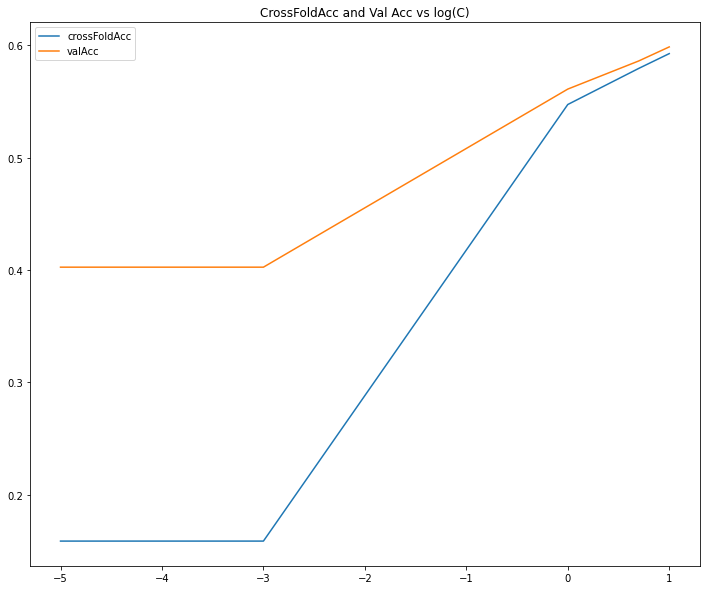

In [37]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,10))
plt.plot(np.log10(checkC),[accDict[i][0] for i in accDict] ,label = 'crossFoldAcc')
plt.plot(np.log10(checkC),[accDict[i][1] for i in accDict] , label = 'valAcc')
plt.legend()
plt.title('CrossFoldAcc and Val Acc vs log(C)')
plt.savefig('images/Q2/CrossFoldGraph.png')

#clearly C = 10 gives the best accuracy 

In [255]:
model10 = SVC(kernel='rbf',gamma = 0.001, C = 10)
model10.fit(trainX,trainY.flatten())

SVC(C=10, gamma=0.001)